In [2]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
torch.set_printoptions(precision=3, linewidth=140,sci_mode=False)
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [3]:
clusters=6
n_samples=250

In [4]:
def sample(mean):
    dist=MultivariateNormal(mean, torch.diag(tensor([5.,5.])))
    return dist.sample((n_samples,))

In [5]:
centroids=torch.rand((clusters, 2))*100-50
centroids.min(),centroids.max(),centroids.shape
slices = [sample(c) for c in centroids]
# slices is list of 6 x (250x2) size tensors - cat joins them into a tensor of same rank, concatenated, not 'stacked'
# so makes 1500 x 2
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [6]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(centroid[0], centroid[1], markersize=10, marker='x', color='k', mew=5)
        ax.plot(centroid[0], centroid[1], markersize=5, marker='x', color='m', mew=2)

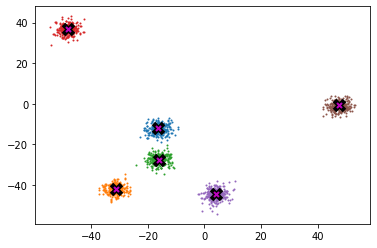

In [7]:
plot_data(centroids, data, n_samples)

In [8]:
def gauss(x, bandwidth):
    numerator = torch.exp(-0.5 * (x/bandwidth)**2)
    return numerator / (bandwidth * math.sqrt(2*math.pi) )

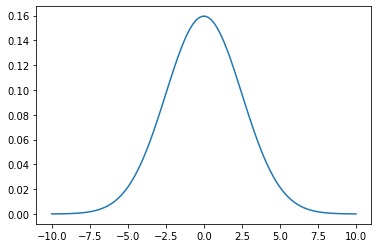

In [9]:
x=torch.linspace(-10,10,100)
plt.plot(x,partial(gauss, bandwidth=2.5)(x))

In [10]:
def one_pass(X, bw):
    for i,x in enumerate(X):
        # get dists to all
        dists = ((x-X)**2).sum(dim=1).sqrt()
        # weight them all according to dists
        weights=gauss(dists, bandwidth=bw)
        # avg them all, weighted, set x
        X[i] = (weights[:,None] * X).sum(0)/weights.sum()

def meanshift(data, loops, bw):
    X=data.clone()
    for i in range(loops):
        one_pass(X,bw)
    return X

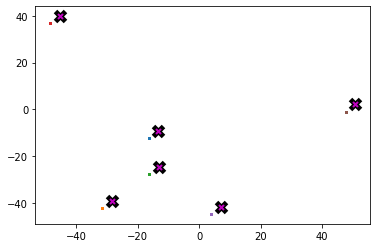

In [11]:
shifted = meanshift(data, 7, 2)
shifted.shape
plot_data(centroids+3, shifted, 250)

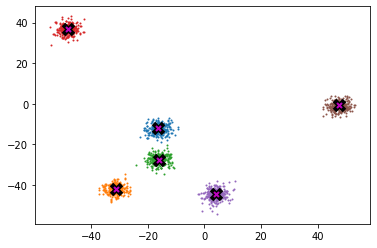

In [12]:
plot_data(centroids, data, 250)

## Animation

In [13]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [14]:
def f(b):
    if b: one_pass(X, 2.5)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)


X = data.clone()
fig,ax=plt.subplots()
ani = FuncAnimation(fig, f, frames=5,interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

In [15]:
def one_pass(X, bw):
    for i,x in enumerate(X):
        # get dists to all
        dists = ((x-X)**2).sum(dim=1).sqrt()
        # weight them all according to dists
        weights=gauss(dists, bandwidth=bw)
        # avg them all, weighted, set x
        X[i] = (weights[:,None] * X).sum(0)/weights.sum()

def meanshift(data, loops, bw):
    X=data.clone()
    for i in range(loops):
        one_pass(X,bw)
    return X

In [16]:
i=0
X=data.clone()
bs=5
batch_x = X[i*bs:(i+1)*bs]
batch_x.shape

torch.Size([5, 2])

In [17]:
dists = ((X-batch_x[:,None])**2).sum(-1).sqrt()
dists.shape # 5, 1500

torch.Size([5, 1500])

In [18]:
weights = gauss(dists, 2.5)
mm=weights @ X
mm,mm.shape

(tensor([[-220.535, -149.952],
         [-335.316, -260.333],
         [-236.932, -172.015],
         [-328.835, -260.296],
         [-242.039, -161.242]]),
 torch.Size([5, 2]))

In [19]:
rr = (mm) / weights.sum(1)[:,None]
X[i*bs:(i+1)*bs]
batch_x-rr

tensor([[ 0.119,  1.739],
        [ 0.379, -0.162],
        [ 0.827,  1.209],
        [ 0.273, -0.540],
        [-0.749,  1.495]])

In [20]:
def meanshift_batch(data, bs, loops):
    X=data.clone()
    for _ in range(loops):
        for i in range(0, len(X), bs):
            batch_x = X[i:i+bs]
            # (bs, 2)
            dists = ((X-batch_x[:,None])**2).sum(-1).sqrt()
            weights = gauss(dists, 2.5)
            # (bs, len(X))
            denominator = weights.sum(1)[:,None]
            # sum across cols, over all the weights which were multiplied by points in X, then add a dim to make it size (bs, 1) for a column vector
            X[i:i+bs] = (weights@X) / denominator
    return X

In [21]:
%%timeit -n 5
r=meanshift(data, 5, 2.5)

1.13 s ± 6.94 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [22]:
datac=data.cuda()

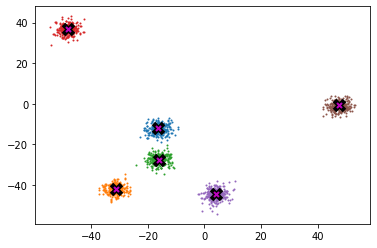

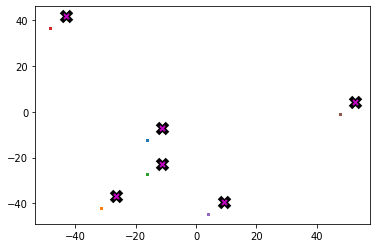

In [23]:
r=meanshift_batch(datac, 100, 5)
plot_data(centroids, data, n_samples)
plot_data(centroids+5, r.cpu(), n_samples)

## DB scan

In [24]:
def plot_data_by_cluster(centroids, clusters, unclustered, ax=None):
    if ax is None:
        ax = plt.subplots(figsize=(10,10))[1]
    for i, centroid in enumerate(centroids):
        ax.plot(centroid[0], centroid[1], markersize=10, marker='x', color='k', mew=5)
        ax.plot(centroid[0], centroid[1], markersize=5, marker='x', color='m', mew=2)
    for c in clusters:
        ax.scatter(c[:,0], c[:,1], s=5)
    ax.scatter(unclustered[:,0], unclustered[:,1], s=5, color='k')

In [25]:
X=data.clone()
dists = (X-X[:,None]).square().sum(-1).sqrt()

In [26]:
threshold = 5
eps = 3

reachable = dists < eps

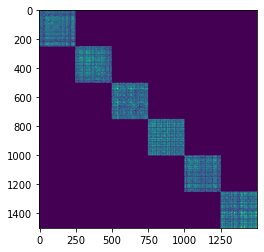

In [27]:
plt.imshow(reachable)

In [28]:
for row in (reachable):
    if row.sum() <= threshold:
        row.zero_()

In [29]:
reachable=reachable.cuda()
prev=reachable.clone()
reachable=reachable.half() @ reachable.half()
prev.equal(reachable)

False

In [30]:
prev=prev.cuda()
reachable=reachable.cuda()
while not prev.equal(reachable):
    i = i + 1
    print(i)
    prev = reachable.clone()
    reachable = (reachable.half() @ reachable.half()) > 0

1
2
3
4


In [31]:
prev.equal(reachable)

True

In [32]:
reachable=reachable.cpu()

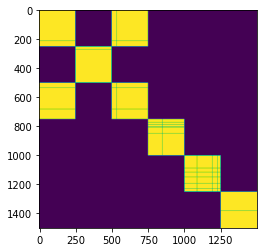

In [33]:
plt.imshow(reachable)

In [34]:
clusters = []
for row in reachable:
    if row.sum() > 0:
        c=row.clone()
        clusters.append(c)
        reachable[c] = 0

In [35]:
list(map(torch.sum, clusters))

[tensor(499), tensor(250), tensor(249), tensor(247), tensor(250)]

In [36]:
clusters = torch.stack(clusters)
clusters.shape

torch.Size([5, 1500])

In [37]:
unclustered = []
for i,x in enumerate(X):
    if not clusters[:,i].any():
        unclustered.append(X[i])
unclustered = torch.stack(unclustered)
num_unclustered = unclustered.shape[0]
unclustered.shape

torch.Size([5, 2])

In [38]:
unclustered = (clusters.any(0) == False)
unclustered.shape,clusters.shape

(torch.Size([1500]), torch.Size([5, 1500]))

In [39]:
torch.sum(torch.tensor([a.sum() for a in clusters])) + num_unclustered

tensor(1500)

In [40]:
from sklearn.cluster import DBSCAN

In [41]:
def dbscan(data, threshold, eps):
    X=data.cuda()
    dists = (X-X[:,None]).square().sum(-1).sqrt()
    reachable = dists < eps

    for row in (reachable):
        if row.sum() <= threshold:
            row.zero_()

    prev=reachable.clone()
    reachable=reachable.half() @ reachable.half()
    prev.equal(reachable)

    while not prev.equal(reachable):
        prev = reachable.clone()
        reachable = reachable.half() @ reachable.half() > 0

    clusters = []
    for row in reachable:
        if row.sum() > 0:
            c=row.clone()
            clusters.append(c)
            reachable[c] = 0

    clusters = torch.stack(clusters)
    unclustered_points = data[(clusters.any(0) == False)]
    cluster_points=[data[c] for c in clusters]
    
    return cluster_points,unclustered_points

clustered: [500, 250, 249, 250, 250], unclustered: 1


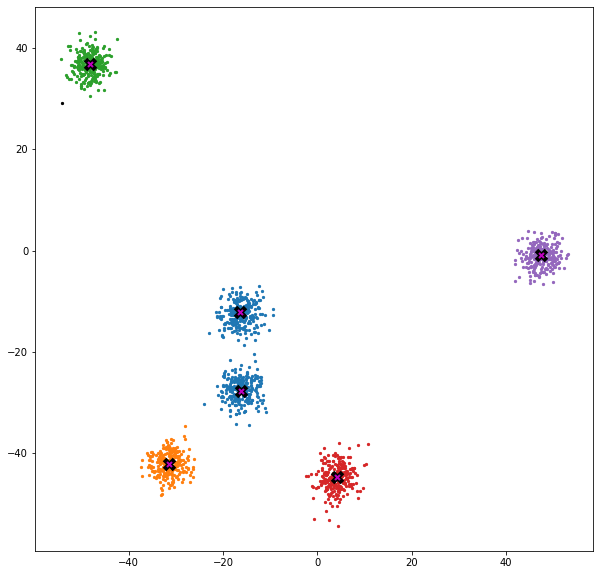

In [42]:
cl,uncl= dbscan(data, 3, 5)
print(f'clustered: {([len(c) for c in cl])}, unclustered: {len(uncl)}')
plot_data_by_cluster(centroids, cl, uncl)

In [43]:
%%timeit -n 5
clustered,unclustered = dbscan(data, 3, 5)

126 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


## db scan - non fixed point solution

In [44]:
eps,threshold

(3, 5)

In [45]:
X=data.cuda()
dists = (X-X[:,None]).square().sum(-1).sqrt()
reachable = dists < eps

for row in (reachable):
    if row.sum() <= threshold:
        row.zero_()


clusters = []
checked=set()
for i,row in enumerate(reachable):
    tocheck=[i]
    cluster=set()
    it = iter(tocheck)
    for j in it:
        #print(f'a - i={i}, j={j}')
        if j in checked:
            continue
        connected = reachable[j].nonzero().squeeze().tolist()
        cluster.update(connected)
        tocheck.extend(connected)
        checked.add(j)
        #print(f'b - tocheck = {tocheck}, connected = {connected}')
    if len(cluster) > 0:
        clusters.append(cluster)

In [60]:
!pip install numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 51.6 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 38.5 MB/s eta 0:00:0000:0100:01


In [61]:
from numba import cuda

In [ ]:
def core_points

In [66]:
def dbscan_nfp(data, threshold, eps):
    X=data.cuda()
    dists = (X-X[:,None]).square().sum(-1).sqrt()
    reachable = dists < eps

    #reachable=reachable.cpu()
    clusters = []
    checked=set()
    for i,row in enumerate(reachable):
        tocheck=[i]
        cluster=set()
        it = iter(tocheck)
        for j in it:
            #print(f'a - i={i}, j={j}')
            if j in checked:
                continue
            if row.sum() <= threshold:
                checked.add(j)
                row.zero_()
                continue
            connected = reachable[j].nonzero().squeeze().tolist()
            cluster.update(connected)
            tocheck.extend(connected)
            checked.add(j)
            #print(f'b - tocheck = {tocheck}, connected = {connected}')
        if len(cluster) > 0:
            clusters.append(cluster)
    
    noise = []
    tmp = torch.zeros((len(clusters), len(data)))
    clusters = [list(c) for c in clusters]
    for i,c in enumerate(clusters):
        tmp[i,c]=1
    unclustered=tmp.any(0)==False
    
    cluster_points = [data[c] for c in clusters]
    unclustered_points=data[unclustered]
    
    return cluster_points,unclustered_points

In [47]:
def dbscan_test(X, threshold, eps):
    dists = (X-X[:,None]).square().sum(-1).sqrt()
    reachable = dists < eps
    for row in (reachable):
        if row.sum() <= threshold:
            None
    #        row.zero_()
    return 0

In [ ]:
%%timeit -n 10
tc=torch.randn(10000000000).cpu()
tc.sum()

In [ ]:
%%timeit -n 10
tg=torch.randn(10000000000).cpu()
tc.sum()

In [48]:
Xcuda=data.cuda()

In [49]:
Xcpu=data.cpu()

In [67]:
%%timeit -n 10
cl,uncl=dbscan_nfp(data, 5, 3)

170 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
nd = data.numpy()

In [56]:
%%timeit -n 10
scanner = DBSCAN(eps=3, min_samples=5)
res = scanner.fit(nd)
#for i in range(-1, 7):
#    print(i, (res.labels_ == i).sum())

8.12 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


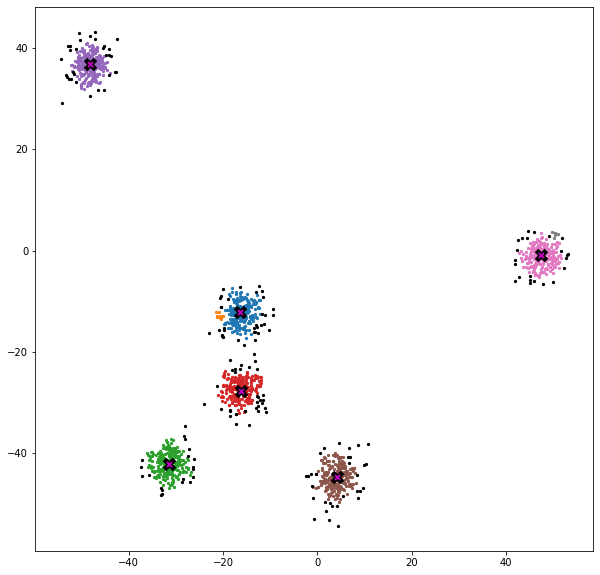

In [57]:
cl,uncl=dbscan_nfp(data, 5, 1)
plot_data_by_cluster(centroids, cl, uncl)